# Lab 6. PyTorch and Recurrent Neural Network

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import numpy as np
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim

In [2]:
from tqdm.notebook import trange, tqdm
from livelossplot import PlotLosses

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

BATCH_SIZE = 64
transform = transforms.Compose([transforms.ToTensor()])

trainset = torchvision.datasets.MNIST(
    root='./data', 
    train=True, 
    download=True, 
    transform=transform)
trainloader = torch.utils.data.DataLoader(
    trainset, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    num_workers=2)

testset = torchvision.datasets.MNIST(
    root='./data', 
    train=False, 
    download=True, 
    transform=transform)
testloader = torch.utils.data.DataLoader(
    testset, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    num_workers=2)


In [4]:
N_STEPS = 28
N_INPUTS = 28
N_NEURONS = 150
N_OUTPUTS = 10
N_EPHOCS = 20

In [5]:
class ImageRNN(nn.Module):
   def __init__(self, batch_size, n_steps, n_inputs, n_neurons, n_outputs):
       super(ImageRNN, self).__init__()
       self.n_neurons = n_neurons
       self.batch_size = batch_size
       self.n_steps = n_steps
       self.n_inputs = n_inputs
       self.n_outputs = n_outputs
       self.basic_rnn = nn.RNN(self.n_inputs, self.n_neurons)
       self.FC = nn.Linear(self.n_neurons, self.n_outputs)

   def init_hidden(self,):
        return (torch.zeros(1, self.batch_size, self.n_neurons).to(device))
       
   def forward(self, X):
       X = X.permute(1, 0, 2)
       self.batch_size = X.size(1)
       self.hidden = self.init_hidden()
       lstm_out, self.hidden = self.basic_rnn(X, self.hidden)
       out = self.FC(self.hidden)
       return out.view(-1, self.n_outputs)

In [6]:
model = ImageRNN(BATCH_SIZE, N_STEPS, N_INPUTS, N_NEURONS, N_OUTPUTS).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [7]:
def get_accuracy(logit, target, batch_size):
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects/batch_size
    return accuracy.item()

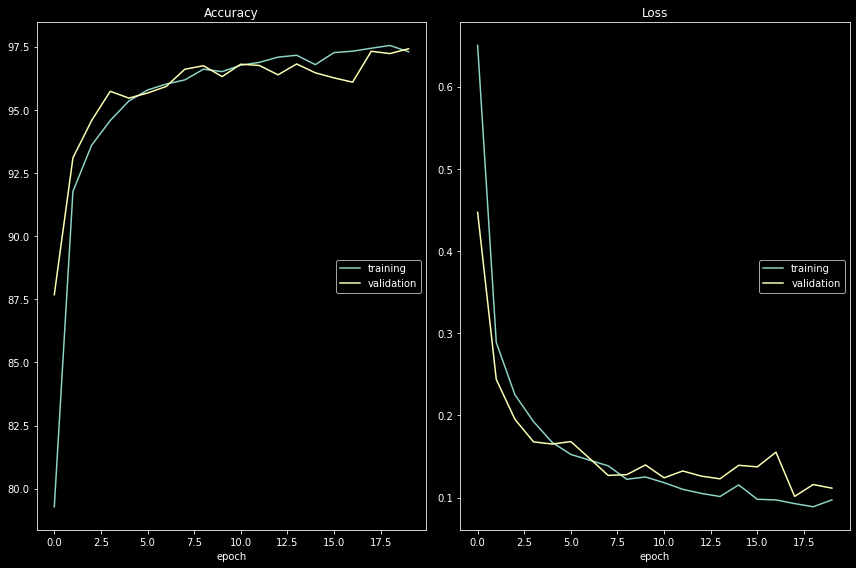

Accuracy
	training         	 (min:   79.284, max:   97.547, cur:   97.299)
	validation       	 (min:   87.680, max:   97.416, cur:   97.416)
Loss
	training         	 (min:    0.089, max:    0.650, cur:    0.097)
	validation       	 (min:    0.101, max:    0.447, cur:    0.111)
Wall time: 2min 32s


In [8]:
%%time
outPbar = tqdm(range(N_EPHOCS))
liveloss = PlotLosses()

for epoch in range(N_EPHOCS):
    logs = {}
    a = 0
    
    for mode in ['train', 'eval']: 
        if mode == 'train': 
            model.train()
            loader = trainloader
        else: 
            model.eval()
            loader = testloader
        running_loss = 0.0
        acc = 0.0
        
        for i, data in enumerate(loader):
            model.hidden = model.init_hidden()
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            inputs = inputs.view(-1, 28,28)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            if mode == 'train':
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            running_loss += loss.detach().item()
            acc += get_accuracy(outputs, labels, BATCH_SIZE)

        prefix = 'val_' if mode == 'eval' else ''
        logs[prefix + 'Loss'] = running_loss / i
        logs[prefix + 'Accuracy'] = acc / i

    outPbar.set_postfix_str(f" Loss: {running_loss / i:.4f} | Accuracy: {acc / i:.2f}")
    a += 1
    outPbar.update(a)
    liveloss.update(logs)
    liveloss.send()

outPbar.close()